In [1]:
##     Heart Tester Version III
##     
##    Authors:  B.K. Eskridge
##              R.K. Thrasher
##


#Common import for data manipulation

import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.signal import decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder



#Importing keras to build neural network

from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
# Directory of datasets and csv file containing info about data    

DAT_DIR = 'heartbeat-sounds/'
SET_A = 'set_a.csv'

In [3]:
#Functions used to help prepare data for Machine Learning

def clean_filename(fname, string):
    """    modifies the filename column in csv file
           returning the filename associated with wav file
    """
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name


def load_wav_file(name, path):
    """    loads wave file returning a numpy array
            of the time-series data
    """
    _ , b = wavfile.read(path + name)
    return b

def load_wav_file_rate(name, path):
    """    returns the sample rate of the
            wav file
    """
    a, b = wavfile.read(path + name)
    return a

def repeat_to_length(arr, length):
    """    Repeats the numpy 1D array to 
           given length, and makes datatype float
    """
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

def prepped_df(old_df):
    """    Returns data frame that is prepared for 
           analysis by filling in missing values and
           storing sound data with proper dimesnions
    """
    df = old_df.copy()
    df['fname'] = df['fname'].apply(clean_filename, string='Aunlabelledtest')
    df['label'] = df['label'].fillna(value = 'unclassified')
    df['time_series'] = df['fname'].apply(load_wav_file, path=DAT_DIR + '/set_a/')
    df['len_series'] = df['time_series'].apply(len)
    MAX_LEN = max(df['len_series'])
    df['time_series'] = df['time_series'].apply(repeat_to_length, length=MAX_LEN)
    return df

In [ ]:
# Using the helper functions above we read in the csv file
# as a pandas dataframe and apply the transformations on the 
# data

In [159]:
df_a = pd.read_csv(DAT_DIR + SET_A)
df = prepped_df(df_a)

In [160]:
# For the sake of our project we remove the unlabled data
# Using the remaining data we will train our algorithm to 
# classify the heartbeat data

df = df[df['label'] != 'unclassified']

In [161]:
# Below we return the unique catagories of the labeled data
#     normal : normal heartrate 
#     murmer : heartbeat containg murmer between S1 and S2 beats
#     artifact : excessive noise or feedback from recording device
#     extrahls : standing for extra heart sounds lables 
#                hearbeat containing additional S1 or S2 like beat
#
list(df.label.unique())

['artifact', 'extrahls', 'murmur', 'normal']

In [7]:
#    Though extrahls type heartbeats can be a sign of a heart pathology  
#    they often show up in healthy hearts. becase of this we relabel them
#    as normal.
#

df['label'].replace(to_replace= 'extrahls', value= 'normal', inplace = True)

In [8]:
#    X and y data for the ML algoritm

x_data = np.stack(df['time_series'].values, axis=0)
y_data = df['label']

In [10]:
#    We relabel the labeled data using a one hot encoder 
#    courtesy of sklearn


yy = y_data.copy()
yy_enc, yy_str = yy.factorize()

encoder_1H = OneHotEncoder()

yy_1h = encoder_1H.fit_transform(yy_enc.reshape(-1,1))
y_data = yy_1h.toarray()

In [14]:
#    Splitting data into testing and training data 
#    

x_train, x_test, y_train, y_test, train_filenames, test_filenames = \
    train_test_split(x_data, y_data, df['fname'].values, test_size=0.25)
    

In [15]:
#    final modifications to training and validation set 
#    using decimation fuction we downsample the heartbeat data
#    which helps in elimination some noise

x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 4, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 4, axis=1, zero_phase=True)


x_train = x_train / np.std(x_train, axis=1).reshape(-1,1)
x_test = x_test / np.std(x_test, axis=1).reshape(-1,1)



x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]


In [16]:
#    Using Keras (A Nerual Network API which uses TensorFlow as its backend)
#    we construct a model containing several convolution layers to be trained
#    on the labeled data



model = Sequential()
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:],
                kernel_regularizer = l2(0.025)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                kernel_regularizer = l2(0.05)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=9, activation='relu',
                 kernel_regularizer = l2(0.1)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(GlobalAvgPool1D())
model.add(Dense(3, activation='softmax'))

In [17]:
#    batch_generator rotates time series data
#    in order to prevent overfitting on the training
#    set


def batch_generator(x_train, y_train, batch_size):
    """
    Rotates the time series randomly in time
    """
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    full_idx = range(x_train.shape[0])

    while True:
        batch_idx = np.random.choice(full_idx, batch_size)
        x_batch = x_train[batch_idx]
        y_batch = y_train[batch_idx]

        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)

        yield x_batch, y_batch


In [18]:
#    weight_saver allows for the saving of the train model

weight_saver = ModelCheckpoint('set_a_weights.h5', monitor='val_loss',
                               save_best_only=True, save_weights_only=True)

In [19]:
#    specifies performance measures to analyze model performance bewteen epochs


model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8**x)

In [21]:
#    Model fit is applied the neural net


hist = model.fit_generator(batch_generator(x_train, y_train, 8),
                   epochs=30, steps_per_epoch=1000,
                   validation_data=(x_test, y_test),
                   callbacks=[weight_saver, annealer],
                   verbose=2)

Epoch 1/30
 - 22s - loss: 2.0402 - acc: 0.4495 - val_loss: 1.4233 - val_acc: 0.5806
Epoch 2/30
 - 20s - loss: 1.2552 - acc: 0.6405 - val_loss: 1.0273 - val_acc: 0.7419
Epoch 3/30
 - 20s - loss: 0.9545 - acc: 0.7135 - val_loss: 0.8334 - val_acc: 0.7742
Epoch 4/30
 - 20s - loss: 0.7853 - acc: 0.7570 - val_loss: 0.8300 - val_acc: 0.6774
Epoch 5/30
 - 20s - loss: 0.6845 - acc: 0.7900 - val_loss: 0.7509 - val_acc: 0.7742
Epoch 6/30
 - 20s - loss: 0.6273 - acc: 0.8006 - val_loss: 0.6596 - val_acc: 0.8065
Epoch 7/30
 - 20s - loss: 0.5642 - acc: 0.8266 - val_loss: 0.6370 - val_acc: 0.8065
Epoch 8/30
 - 20s - loss: 0.5386 - acc: 0.8318 - val_loss: 0.6340 - val_acc: 0.7742
Epoch 9/30
 - 21s - loss: 0.4882 - acc: 0.8538 - val_loss: 0.6371 - val_acc: 0.7742
Epoch 10/30
 - 20s - loss: 0.4653 - acc: 0.8620 - val_loss: 0.6780 - val_acc: 0.7742
Epoch 11/30
 - 20s - loss: 0.4700 - acc: 0.8638 - val_loss: 0.6749 - val_acc: 0.8065
Epoch 12/30
 - 20s - loss: 0.4590 - acc: 0.8663 - val_loss: 0.6221 - val_a

In [22]:
model.load_weights('set_a_weights.h5')

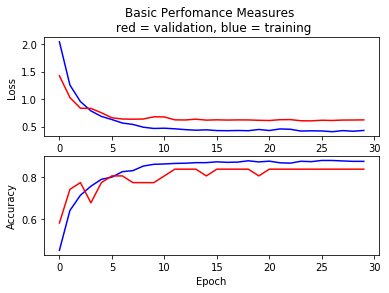

In [158]:

plt.subplot(2, 1, 1)
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.title('Basic Perfomance Measures \n red = validation, blue = training')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
#              ACKNOWLEDGEMENTS 
#
#   A liberal use of publically availabe code was used provided
#   by Peter Grenholm
#
#   The heartbeat data was orginally provided to Kaggle through
#      @misc{pascal-chsc-2011,
#       author = "Bentley, P. and Nordehn, G. and Coimbra, M. and Mannor, S.",
#       title = "The {PASCAL} {C}lassifying {H}eart {S}ounds {C}hallenge 2011 {(CHSC2011)} {R}esults",
#       howpublished = "http://www.peterjbentley.com/heartchallenge/index.html"} 
#
#